# Image Characteristic Extraction for Image Deblurring Performance Analysis

- **Project**: Statistical Analysis of Image Deblurring Methods Performance
- **Dataset**: ~1000 high-resolution and diverse images from HQ-50K
- **Goal**: Extract image-level features (contrast, edge density and strength) to enable statistical correlations between image characteristics, blur types, deblurring methods (classical and AI), and output quality metrics.

## Scope of this script:

This module is part of the "Original Images Processing" phase and focuses on:

- image_contrast: global contrast of the original image
- edge_strength: average gradient magnitude across all pixels
- edge_density: proportion of pixels classified as edges

These are **independent variables** in our dataset and are critical for:

- understanding how image content affects perceived blur
- analyzing performance variation across deblurring methods
- grouping images by visual complexity and texture

## Chosen methods:

1. **RMS Contrast**:

   - What it measures: global variation in pixel intensity (grayscale)
   - Why it's appropriate: blur reduces intensity variance; RMS contrast is continuous, robust, and invariant to illumination changes

2. **Sobel Gradient Magnitude (Edge Strength)**:

   - What it measures: average strength of image gradients (edges)
   - Why it's appropriate: blur directly weakens gradient transitions
   - Gaussian smoothing is applied before Sobel to reduce spurious gradients

3. **Canny Edge Detection (Edge Density)**:
   - What it measures: proportion of pixels classified as edges
   - Why it's appropriate: blur directly weakens gradient transitions
   - Gaussian smoothing is applied before Canny to reduce spurious gradients

These features are extracted from **original high-resolution images** (before blur or deblurring), aligned with the project roadmap.

**Output**: a `.parquet` file with columns _rms_contrast_, _sobel_edge_strength_ and _canny_edge_density_ added to be used later in correlation analysis and performance prediction models.


In [1]:
import sys
sys.path.append("../..")

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import logging

from utils import compute_rms_contrast, compute_sobel_edge_strength, compute_canny_edge_density

# Gaussian filter to suppress noise before edge detection
GAUSSIAN_PARAMS = {
    'ksize': (3, 3),
    'sigma': 1.0
}

# Sobel kernel size
SOBEL_PARAMS = {
    'ksize': 3
}

# Configure logging
logging.basicConfig(
    filename='2_image_characteristic_extraction.log',
    level=logging.ERROR,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def extract_features_from_dataset(
    dataset_parquet_path: str,
    dir_images_path: str,
    save: bool = True,
    subset: int = None,
    backup: bool = False
) -> pd.DataFrame:
    """
    Extracts rms_contrast, sobel_edge_strength and canny_edge_density from images listed in a dataset.

    Args:
        dataset_parquet_path: .parquet file containing at least 'key' column
        dir_images_path: Directory where image files are stored
        save (optional): Boolean to define whether the script should save the updated dataset
        subset (optional): The size of the subset to process
        backup (optional): Boolean to define whether to create a backup of the dataset (dataset_parquet_path)

    Returns:
        Updated DataFrame from dataset_parquet_path with added rms_contrast, sobel_edge_strength
    """
    df = pd.read_parquet(dataset_parquet_path)

    if backup:
        backup_path = dataset_parquet_path.with_name(f"bck_{dataset_parquet_path.name}")
        df.to_parquet(backup_path, index=False)

    df["rms_contrast"] = np.nan
    df["sobel_edge_strength"] = np.nan
    df["canny_edge_density"] = np.nan

    if subset:
        df = df[:subset]

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        image_id = row['key']
        img_format = row['format'].lower() if 'format' in row and pd.notna(row['format']) else "png"

        ext = '.jpg' if img_format and img_format == 'jpeg' else f'.{img_format}'
        image_path = os.path.join(dir_images_path, f"{image_id}{ext}")

        if not os.path.exists(image_path):
            logging.error(f"File not found: {image_path}")
            continue

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            logging.error(f"Failed to load image ID {image_id}")
            continue

        try:
            contrast = compute_rms_contrast(img)
            _, edge_strength = compute_sobel_edge_strength(
                img,
                GAUSSIAN_PARAMS,
                SOBEL_PARAMS
            )
            _, edge_density = compute_canny_edge_density(
                img,
                GAUSSIAN_PARAMS
            )

            df.at[idx, "rms_contrast"] = contrast
            df.at[idx, "sobel_edge_strength"] = edge_strength
            df.at[idx, "canny_edge_density"] = edge_density

        except Exception as e:
            logging.error(f"Error processing image ID {image_id}: {e}")

    if save:
        df.to_parquet(dataset_parquet_path, index=False)

    print(f"\nFeature extraction complete.")
    return df

In [3]:
from pathlib import Path

ROOT_PATH = Path.cwd().parent.parent
DIR_DATASET_PATH =  ROOT_PATH / "data" / "image-deblurring-performance-analysis"
ORIGINAL_DATASET_PATH = DIR_DATASET_PATH / "original"
MAIN_DATASET_PATH = DIR_DATASET_PATH / "image_deblurring_dataset.parquet"

df = extract_features_from_dataset(
    dataset_parquet_path=MAIN_DATASET_PATH, 
    dir_images_path=ORIGINAL_DATASET_PATH / "00000",
    backup=True
)

Extracting features: 100%|██████████| 1250/1250 [01:45<00:00, 11.85it/s]


Feature extraction complete.


In [4]:
print(f"RMS Contrast:  \t\tMax: {df["rms_contrast"].max():.3f},\t\tMin: {df["rms_contrast"].min():.3f}")
print(f"Sobel Edge Strength:  \tMax: {df["sobel_edge_strength"].max():.3f},\t\tMin: {df["sobel_edge_strength"].min():.3f}")
print(f"Canny Edge Density:  \tMax: {df["canny_edge_density"].max():.3f},\t\tMin: {df["canny_edge_density"].min():.3f}")
display(df)

RMS Contrast:  		Max: 0.431,		Min: 0.060
Sobel Edge Strength:  	Max: 203.722,		Min: 8.267
Canny Edge Density:  	Max: 0.373,		Min: 0.000


,url,category,key,width,height,exif,aspect_ratio,size,rms_contrast,sobel_edge_strength,canny_edge_density
0,http://100500foto.com/wp-content/uploads/2016/...,people,000000291,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
1,http://2gfsl7am0og1m91u0pwpiehl.wpengine.netdn...,indoor_scene,000000987,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
2,http://411posters.com/wp-content/uploads/2011/...,poster,000000382,1300.0,1728.0,{},0.752315,3169036.0,0.373365,54.414061,0.139681
3,http://RealEstateAdminImages.gabriels.net/170/...,architecture,000000058,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
4,http://RealEstateAdminImages.gabriels.net/170/...,architecture,000000001,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1245,https://www.yamaha.com/en/musical_instrument_g...,complex,000000564,1800.0,1042.0,{},1.727447,3199285.0,0.331964,60.298111,0.093565
1246,https://www.yellowmaps.com/usgs/topomaps/drg24...,map,000001225,1509.0,2026.0,"{""Image Tag 0x5100"": ""0""}",0.744817,5742001.0,0.221090,99.311477,0.177919
1247,https://www.zappos.com/images/z/2/5/1/8/8/7/25...,furniture,000000481,1920.0,1440.0,{},1.333333,4276346.0,0.253243,53.379880,0.086103
1248,https://ycdn.space/h/2015/02/Capitol-Hill-Loft...,indoor_scene,000000954,1050.0,1575.0,{},0.666667,2000861.0,0.241754,64.152358,0.085650


,url,category,key,width,height,exif,aspect_ratio,size,rms_contrast,sobel_edge_strength,canny_edge_density
297,https://backbayhouses.files.wordpress.com/2013...,map,000001231,2163.0,1650.0,{},1.310909,5203658.0,0.169613,60.167730,0.070743
1224,https://www.stuckinamoment.com.au/wp-content/u...,people,000000223,2048.0,1535.0,"{""Image Make"": ""Canon"", ""Image Model"": ""Canon ...",1.334202,5652677.0,0.226915,60.561743,0.123748
904,https://mapcruzin.com/free-maps-burma-myanmar/...,map,000001200,1180.0,1458.0,{},0.809328,2052727.0,0.227089,73.056830,0.082073
1040,https://static.wikia.nocookie.net/marveldataba...,comic,000000742,1073.0,1650.0,{},0.650303,2571133.0,0.356160,81.968792,0.113829
1140,https://www.contemporaryrugs.eu/wp-content/upl...,furniture,000000413,1038.0,1280.0,{},0.810937,2103153.0,0.202896,31.022410,0.085782


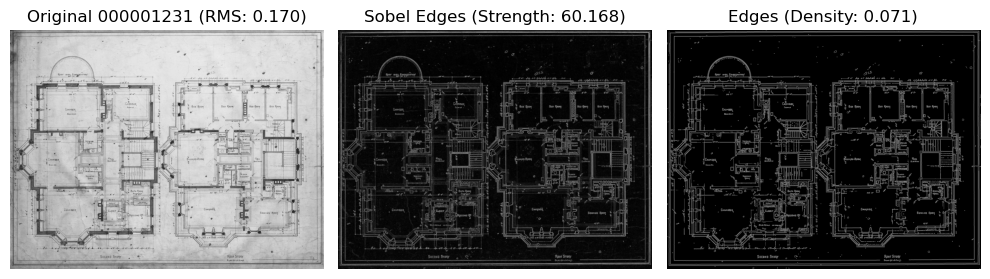

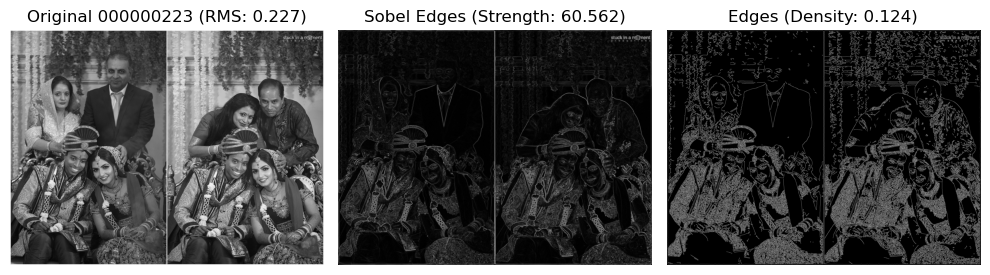

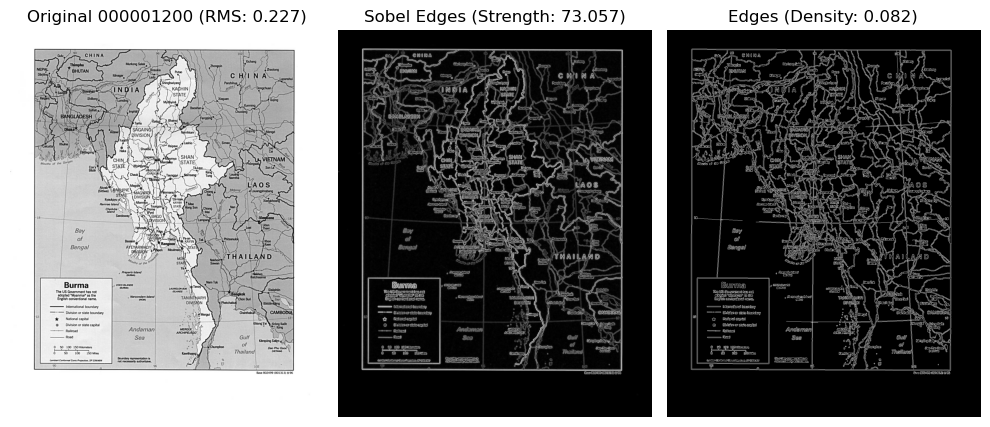

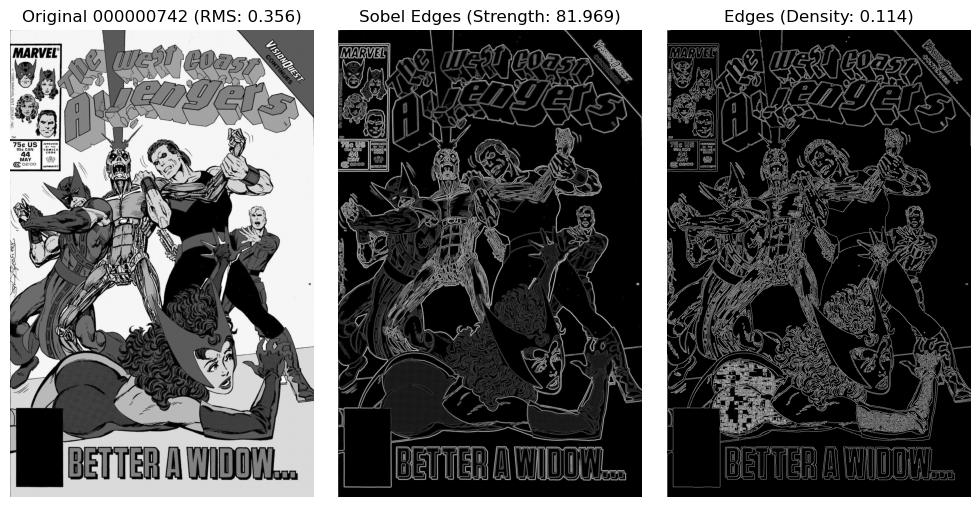

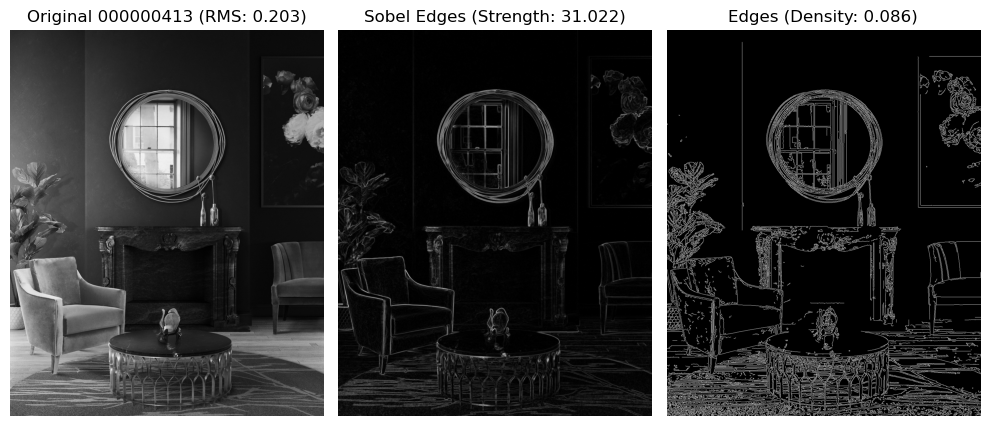

In [5]:
import matplotlib.pyplot as plt

from utils import compute_sobel_edge_strength, compute_canny_edge_density

random_rows = df.dropna().sample(n=5, random_state=42)
display(random_rows)
for i, (_, row) in enumerate(random_rows.iterrows(), 1):
    img_id = row["key"]
    image_path = ORIGINAL_DATASET_PATH / "00000" / f"{img_id}.png"
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if not isinstance(image, np.ndarray) or image.size == 0 or image.ndim != 2:
        raise ValueError("Input must be a valid grayscale image (2D NumPy array)")

    img_sobel, _= compute_sobel_edge_strength(
        image,
        GAUSSIAN_PARAMS,
        SOBEL_PARAMS
    )

    img_canny, _ = compute_canny_edge_density(
        image,
        GAUSSIAN_PARAMS
    )

    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original {img_id} (RMS: {row['rms_contrast']:.3f})")
    plt.axis('off')

    # Plot Sobel edges
    plt.subplot(1, 3, 2)
    plt.imshow(img_sobel, cmap='gray')
    plt.title(f"Sobel Edges (Strength: {row['sobel_edge_strength']:.3f})")
    plt.axis('off')

    # Plot Canny edges
    plt.subplot(1, 3, 3)
    plt.imshow(img_canny, cmap='gray')
    plt.title(f"Edges (Density: {row['canny_edge_density']:.3f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()